<a href="https://colab.research.google.com/github/jeffiThomas/IoTAgricultureProject/blob/main/notebooks/Models03.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
#load data
from google.colab import drive
drive.mount('/content/drive')
import pandas as pd

data_path = "/content/drive/MyDrive/IoTAgricultureProject/data/"

loaded_df = pd.read_parquet(data_path + "merged_iot_data.parquet")

display(loaded_df.head())

Mounted at /content/drive


,timestamp,Environment Temperature (Celsius),Environment Humidity (%),Environment Light Intensity (Lux),Soil Moisture (%),Soil pH (pH),Soil Temperature (Celsius),Solar Panel Battery Voltage (Volts),Water TDS (mg/L)
0,2024-09-27 12:58:10+05:30,26.2,95,50.83,61.88,6.1,18.1,3.550,130.68
1,2024-09-27 12:58:28+05:30,26.2,95,36.67,61.58,6.1,18.1,3.552,128.89
2,2024-09-27 12:59:03+05:30,26.2,95,39.17,61.88,6.1,18.1,3.554,128.89
3,2024-09-27 12:59:22+05:30,26.2,95,39.17,59.24,6.1,18.1,3.556,155.42
4,2024-09-27 12:59:45+05:30,26.2,95,30.83,31.48,6.1,18.1,3.557,130.68


#Set Target Variable (Soil Moisture) and Feature Variables

In [7]:
target_col = 'Soil Moisture (%)'

feature_cols = [
    'Environment Temperature (Celsius)',
    'Environment Humidity (%)',
    'Environment Light Intensity (Lux)',
    'Soil pH (pH)',
    'Soil Temperature (Celsius)',
    'Solar Panel Battery Voltage (Volts)',
    'Water TDS (mg/L)'
]

X = loaded_df[feature_cols].values
y = loaded_df[target_col].values



#Feature Scaling

In [8]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


#LOOCV Utility Function

In [9]:
from sklearn.model_selection import LeaveOneOut
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np
def loocv_regression(model, X, y):
    loo = LeaveOneOut()

    y_true = []
    y_pred = []

    for train_idx, test_idx in loo.split(X):
        X_train, X_test = X[train_idx], X[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]

        model.fit(X_train, y_train)
        pred = model.predict(X_test)

        y_true.append(y_test[0])
        y_pred.append(pred[0])

    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)

    return rmse, mae


#Baseline Model 1: Linear Regression

Linear regression was selected as a foundational baseline model to determine whether soil moisture could be predicted using linear combinations of environmental and soil sensor inputs. This is to be able to compare simpler models to deep learning approaches to see if deep learning adds any benefit.

In [10]:
from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression()
rmse_lr, mae_lr = loocv_regression(lin_reg, X_scaled, y)

print("Linear Regression LOOCV Results")
print(f"RMSE: {rmse_lr:.3f}")
print(f"MAE: {mae_lr:.3f}")


Linear Regression LOOCV Results
RMSE: 10.078
MAE: 4.127


RMSE of 10.08 and MAE of 4.13 shows that the model captures some predictive signal, that there is moderate predictie ability due to some error, and that there is in fact a linear relationship between the sensors and soil moisture,

#Baseline Model 2: Decision Tree Regression

Deicision trees were selected to model the nonlinear relationships between environemental variables and soil moisture. Decision trees are an effective choice for small samlle scenarios to capture threshold effects.

In [11]:
from sklearn.tree import DecisionTreeRegressor

dt = DecisionTreeRegressor(
    max_depth=4,  # prevent overfitting
    random_state=42
)

rmse_dt, mae_dt = loocv_regression(dt, X_scaled, y)

print("Decision Tree LOOCV Results")
print(f"RMSE: {rmse_dt:.3f}")
print(f"MAE: {mae_dt:.3f}")


Decision Tree LOOCV Results
RMSE: 10.046
MAE: 3.994


RMSE of 10.05 and MAE of 3.99 shows a slight improvement over linear regression. It shows that nonlinear effects are present but that they arent very complex.

In [12]:
#store results
results = pd.DataFrame({
    "Model": ["Linear Regression", "Decision Tree"],
    "RMSE": [rmse_lr, rmse_dt],
    "MAE": [mae_lr, mae_dt]
})

display(results)


,Model,RMSE,MAE
0,Linear Regression,10.078199,4.127207
1,Decision Tree,10.045757,3.994324


##MLP - Deep Learning

Multilayer Perceptron was selected to model th complex linear interactions between the multiple sensor inputs and soil moisture output. I kept the architecture small to avoid overfitting becuase the dataset was so small, and used LOOCV to maximize training data untilization.

In [13]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.callbacks import EarlyStopping

def build_mlp(input_dim):
    model = Sequential([
        Dense(16, activation='relu', input_shape=(input_dim,)),
        Dense(8, activation='relu'),
        Dense(1)  # regression output
    ])

    model.compile(
        optimizer='adam',
        loss='mse'
    )

    return model

In [14]:
from sklearn.model_selection import LeaveOneOut
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np
loo = LeaveOneOut()

y_true = []
y_pred = []

for train_idx, test_idx in loo.split(X_scaled):
    X_train, X_test = X_scaled[train_idx], X_scaled[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]

    model = build_mlp(X_train.shape[1])

    early_stop = EarlyStopping(
        monitor='loss',
        patience=10,
        restore_best_weights=True,
        verbose=0
    )

    model.fit(
        X_train,
        y_train,
        epochs=200,
        batch_size=8,
        verbose=0,
        callbacks=[early_stop]
    )

    pred = model.predict(X_test, verbose=0)

    y_true.append(y_test[0])
    y_pred.append(pred[0][0])


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [18]:
#metrics
rmse_mlp = np.sqrt(mean_squared_error(y_true, y_pred))
mae_mlp = mean_absolute_error(y_true, y_pred)

print("MLP LOOCV Results")
print(f"RMSE: {rmse_mlp:.3f}")
print(f"MAE: {mae_mlp:.3f}")


#store results
results = pd.concat([
    results,
    pd.DataFrame({
        "Model": ["MLP (Deep Learning)"],
        "RMSE": [rmse_mlp],
        "MAE": [mae_mlp]
    })
], ignore_index=True)

display(results)


MLP LOOCV Results
RMSE: 15.701
MAE: 5.816


,Model,RMSE,MAE
0,Linear Regression,10.078199,4.127207
1,Decision Tree,10.045757,3.994324
2,MLP (Deep Learning),15.701475,5.816317


RMSE of 15.70 and MAe of 5.82 shows that the performace actually went down compared to the simpler models. It might indicate that there is osme overfitting with the data scarcity. This demonstrates how deep learning is not always the superior choice. Model complexity must match the data scale. IoT deployments with limited historical data could actualy benefit from simpler models as deep learning requires sufficient training volume.

##LSTM Time Series

An LSTM network was selected to model the temporal dependencies in environmental temperature readings using sliding windows and walk-forward validation.

In [19]:
#extracting the temperature series
temp_series = loaded_df['Environment Temperature (Celsius)'].values


In [20]:
#scaling
from sklearn.preprocessing import MinMaxScaler

ts_scaler = MinMaxScaler()
temp_scaled = ts_scaler.fit_transform(temp_series.reshape(-1, 1))


In [22]:
#sequences
def create_sequences(data, window_size=3):
    X, y = [], []
    for i in range(len(data) - window_size):
        X.append(data[i:i+window_size])
        y.append(data[i+window_size])
    return np.array(X), np.array(y)

WINDOW_SIZE = 3

X_ts, y_ts = create_sequences(temp_scaled, WINDOW_SIZE)

print("Sequence shape:", X_ts.shape)


Sequence shape: (96, 3, 1)


In [23]:
#lstm model
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping

def build_lstm():
    model = Sequential([
        LSTM(16, input_shape=(WINDOW_SIZE, 1)),
        Dense(1)
    ])

    model.compile(
        optimizer='adam',
        loss='mse'
    )

    return model


In [24]:
#walkforward LOOCV

y_true = []
y_pred = []

for i in range(len(X_ts)):
    X_train = X_ts[:i+1]
    y_train = y_ts[:i+1]
    X_test = X_ts[i:i+1]
    y_test = y_ts[i:i+1]

    model = build_lstm()

    early_stop = EarlyStopping(
        monitor='loss',
        patience=10,
        restore_best_weights=True,
        verbose=0
    )

    model.fit(
        X_train,
        y_train,
        epochs=200,
        batch_size=4,
        verbose=0,
        callbacks=[early_stop]
    )

    pred = model.predict(X_test, verbose=0)

    y_true.append(y_test[0][0])
    y_pred.append(pred[0][0])



/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [25]:
#inv scale + metrics
y_true_inv = ts_scaler.inverse_transform(np.array(y_true).reshape(-1, 1))
y_pred_inv = ts_scaler.inverse_transform(np.array(y_pred).reshape(-1, 1))

rmse_lstm = np.sqrt(mean_squared_error(y_true_inv, y_pred_inv))
mae_lstm = mean_absolute_error(y_true_inv, y_pred_inv)

print("LSTM Time Series Results")
print(f"RMSE: {rmse_lstm:.3f}")
print(f"MAE: {mae_lstm:.3f}")


LSTM Time Series Results
RMSE: 0.057
MAE: 0.039


RMSE of 0.057 and MAE of 0.039 signifies that the network was very effective at the short-term forecasting accuracy. The temperature changes smoothly over time, which made it predictable and effective. Walk-forward validation preserved the temporal integrity.

##Plots

Actual vs Predicted (MLP)

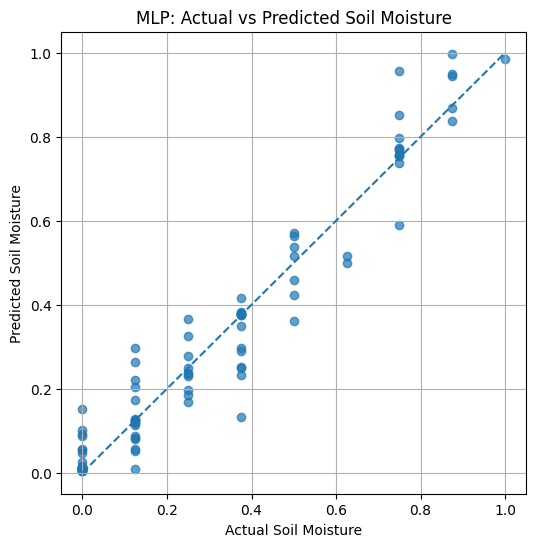

In [26]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6, 6))
plt.scatter(y_true, y_pred, alpha=0.7)
plt.plot([min(y_true), max(y_true)], [min(y_true), max(y_true)], linestyle='--')
plt.xlabel("Actual Soil Moisture")
plt.ylabel("Predicted Soil Moisture")
plt.title("MLP: Actual vs Predicted Soil Moisture")
plt.grid(True)
plt.show()


Actual vs Predicted Time Series LSTM

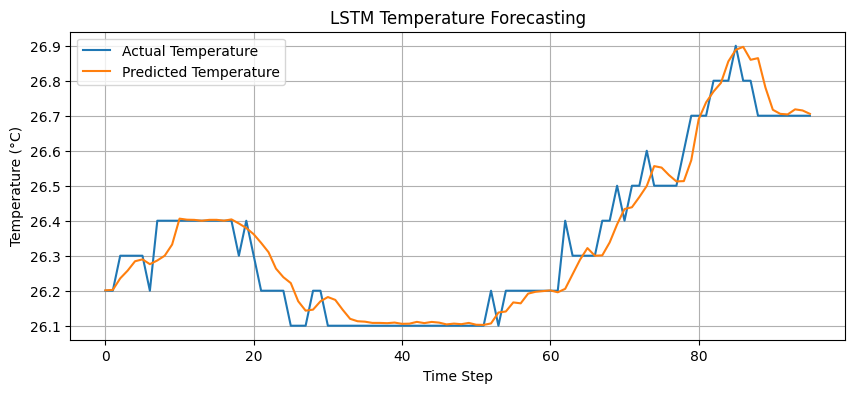

In [27]:
plt.figure(figsize=(10, 4))
plt.plot(y_true_inv, label="Actual Temperature")
plt.plot(y_pred_inv, label="Predicted Temperature")
plt.xlabel("Time Step")
plt.ylabel("Temperature (°C)")
plt.title("LSTM Temperature Forecasting")
plt.legend()
plt.grid(True)
plt.show()


Error Distribution

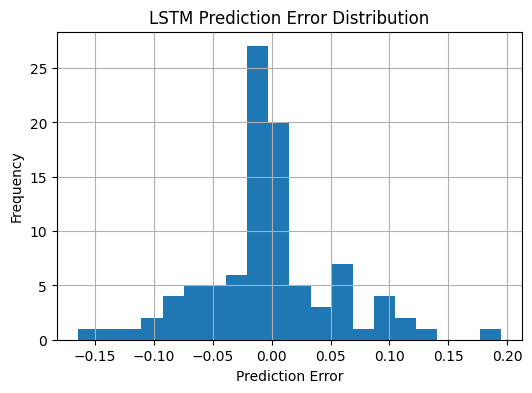

In [28]:
errors = y_true_inv.flatten() - y_pred_inv.flatten()

plt.figure(figsize=(6, 4))
plt.hist(errors, bins=20)
plt.xlabel("Prediction Error")
plt.ylabel("Frequency")
plt.title("LSTM Prediction Error Distribution")
plt.grid(True)
plt.show()


#Visuals Discussion TODO

#Synthetic Data Augmentation Experiment

Synthetic data augmentation was selected just to try to see if we could simulate realistic sensor variability to see if performance limitations were a result of insufficient data volume.

In [29]:
numeric_cols = feature_cols + [target_col]
base_df = loaded_df[numeric_cols].copy()


In [30]:
import numpy as np

def generate_synthetic_data(df, noise_level=0.05, n_samples=100):
    synthetic_rows = []

    for _ in range(n_samples):
        row = df.sample(1).values.flatten()
        noise = np.random.normal(
            loc=0,
            scale=noise_level * np.std(df.values, axis=0),
            size=row.shape
        )
        synthetic_rows.append(row + noise)

    return pd.DataFrame(synthetic_rows, columns=df.columns)

synthetic_df = generate_synthetic_data(base_df, n_samples=99)

augmented_df = pd.concat([base_df, synthetic_df], ignore_index=True)

print("Original size:", base_df.shape)
print("Augmented size:", augmented_df.shape)


Original size: (99, 8)
Augmented size: (198, 8)


In [31]:
#run model
X_aug = augmented_df[feature_cols].values
y_aug = augmented_df[target_col].values

X_aug_scaled = scaler.fit_transform(X_aug)

rmse_aug, mae_aug = loocv_regression(LinearRegression(), X_aug_scaled, y_aug)

print("Augmented Data Results (Linear Regression)")
print(f"RMSE: {rmse_aug:.3f}")
print(f"MAE: {mae_aug:.3f}")


Augmented Data Results (Linear Regression)
RMSE: 6.345
MAE: 3.266


The results from the augmented linear regression were an RMSE of 6.35 and MAE of 3.27 which actually shows a significant performance improvement. It shows that there could have been instability in regression coefficients because of the limited data. This is a significant finding because it suggests that more real world data from the sensors could improve predictive performance.